# HH fitting to HH with wider ranges

In [1]:
from brian2 import *
from brian2tools import *


prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

INFO       Cache size for target "cython": 1019 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Input Data Preparation

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA

input_current2 = np.stack((input_current0, input_current1))

In [4]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [5]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+ VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [7]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

In [8]:
# Generate Proper Input Format for the Problem
inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_trace = np.concatenate(([out_trace0], [out_trace1]))

## Model Fitting 

In [9]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
''',
# Cm=1*ufarad*cm**-2 * area,
El=-65*mV, EK=-90*mV, ENa=50*mV,
VT=-63*mV)

In [10]:
start_scope()
n_opt = SkoptOptimizer(method='GP')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 2*1e3*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 1*1e3*msiemens*cm**-2 * area],
                                   Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                                   n_rounds=3, n_samples=30, optimizer=n_opt, metric=metric)

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]
INFO       No numerical integration method specified for group 'neurons', using method 'exponential_euler' (took 0.18s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]


round 0 with error [0.50542555 0.50542555 0.50542555 0.50542555]
round 1 with error []
round 2 with error [0.49316245 0.49316245 0.49316245 0.49316245]


## Results Visualization

In [11]:
# get information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'gl': 1.4899714669270743e-07, 'Cm': 1.9015092881660216e-10, 'g_na': 0.00014631967816305174, 'g_kd': 0.00013237765614594775}
error [0.49316245 0.49316245 0.49316245 0.49316245]


In [12]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='v',
                     dt=dt)

fits/mV

array([[  0.        ,  -0.50733224,  -1.01061559, ..., -65.29687837,
        -65.29397579, -65.29109463],
       [  0.        ,  -0.50733224,  -1.01061559, ..., -64.78676375,
        -64.78768559, -64.78860022]])

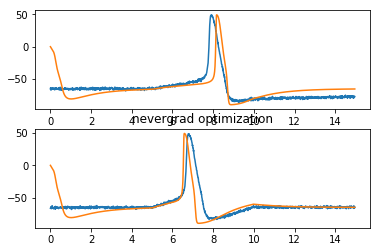

In [13]:
fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(out_trace[0]))*dt/ms, out_trace[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);
ax[1].plot(np.arange(len(out_trace[1]))*dt/ms, out_trace[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);
plt.title('nevergrad optimization')
# plt.savefig('plots/hh_nevergrad.png')
plt.show()